### 1. read the data and data processing

read the transaction data(csv or json)

In [1]:
import pandas as pd

In [2]:
# read sample.csv
transaction_df = pd.read_csv("sample.csv")
# data processing
transaction_df = transaction_df.iloc[3:]
date_time_split = transaction_df['Portfolio ID'].str.split('T', expand=True)
transaction_df['date'] = date_time_split[0]
transaction_df['time'] = date_time_split[1].str[:8]
transaction_df['time'] = pd.to_datetime(transaction_df['time'],format= '%H:%M:%S' ).dt.time

transaction_df = transaction_df.rename(columns={'User Name': 'tic', 'Cash Left':'Qty','Unnamed: 7':'Amount'})

transaction_df = transaction_df[['date','time','tic','Qty','Amount']]
transaction_df['Qty'] = pd.to_numeric(transaction_df['Qty'], errors='coerce', downcast='integer')
transaction_df['Amount'] = pd.to_numeric(transaction_df['Amount'], errors='coerce', downcast='integer')

transaction_df['Price'] = abs(transaction_df['Amount']/transaction_df['Qty'])
transaction_df.loc[transaction_df['Amount'] < 0, 'Qty'] *= -1

transaction_df['time'] = pd.to_datetime(transaction_df['time'],format= '%H:%M:%S' ).dt.time
tran = transaction_df.groupby(['date','tic'])['Qty'].sum()
cha = transaction_df.groupby(['date','tic'])['Amount'].sum()
my_dataframe = pd.DataFrame({'Qty_chg': tran})
my_dataframe['Amount_chg'] = cha
my_dataframe['Qty']  = my_dataframe.groupby(['tic'])['Qty_chg'].cumsum()
my_dataframe['Amount']  = my_dataframe['Amount_chg'].cumsum()

In [3]:
my_dataframe.head()

Qty_chg  Amount_chg   Qty    Amount
date       tic                                      
2023-05-22 AAPL     2000    348000.0  2000  348000.0
           AMZN     1500    172500.0  1500  520500.0
           MSFT      180     57600.0   180  578100.0
           SBUX      750     77250.0   750  655350.0
           TSLA     1600    299750.0  1600  955100.0

get the daily return data

In [4]:
from yahoodownloader import YahooDownloader 

tickers = set(transaction_df['tic'])
Start_Date = '2023-05-01'
End_Date = '2023-11-03'

daily_return_df = YahooDownloader(start_date = Start_Date,
                     end_date = End_Date,
                     ticker_list = tickers).fetch_data()


daily_return_df = daily_return_df.drop(['open','high','low','volume'], axis=1)
daily_return_df = daily_return_df.set_index(['date','tic'])

daily_return_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1430, 8)


close  day
date       tic                  
2023-05-01 AAPL  169.127365    0
           AMZN  102.050003    0
           DX     10.728498    0
           FAST   53.924286    0
           KO     63.311699    0

merge the daily return and transaction data

In [5]:
initial_balance = 1000000
merged_data = pd.merge(daily_return_df, my_dataframe, left_on=['date','tic'], right_on=['date','tic'], how='outer', indicator=True)
merged_data['Amount'] = merged_data['Amount'].ffill()
merged_data['Qty']  = merged_data.groupby(['tic'])['Qty'].ffill()

merged_data = merged_data.drop(['day','Qty_chg','Amount_chg','_merge'],axis=1)
merged_data =merged_data.fillna(0)
merged_data['Investing_value'] = merged_data['close'] * merged_data['Qty']
merged_data['Cash'] = initial_balance - merged_data['Amount']

merged_data.head()

close  Qty  Amount  Investing_value       Cash
date       tic                                                      
2023-05-01 AAPL  169.127365  0.0     0.0              0.0  1000000.0
           AMZN  102.050003  0.0     0.0              0.0  1000000.0
           DX     10.728498  0.0     0.0              0.0  1000000.0
           FAST   53.924286  0.0     0.0              0.0  1000000.0
           KO     63.311699  0.0     0.0              0.0  1000000.0

In [6]:
investing_value = merged_data.groupby('date')['Investing_value'].sum()

In [7]:
cash = merged_data.groupby('date')['Cash'].last()

In [8]:
portfolio_value = investing_value + cash

In [9]:
portfolio_value

date
2023-05-01    1.000000e+06
2023-05-02    1.000000e+06
2023-05-03    1.000000e+06
2023-05-04    1.000000e+06
2023-05-05    1.000000e+06
                  ...     
2023-10-27    9.880435e+05
2023-10-30    9.923507e+05
2023-10-31    9.992460e+05
2023-11-01    1.014702e+06
2023-11-02    1.053728e+06
Length: 130, dtype: float64

### 2. Encapsulate all the process and get our portfolio daily return

In [10]:
from dataprocessing import DataProcessing           
# find the code in dataprocessing.py

Start_Date = '2023-05-01'
End_Date = '2023-11-03'
csv_file = 'sample.csv'

processor = DataProcessing(Start_Date, End_Date, csv_file)
portfolio_value = processor.portfolio_value
sp500 = processor.sp500_portfolio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
from financialmetrics import FinancialMetrics 

In [12]:
fm = FinancialMetrics(portfolio_value, sp500)

In [13]:
ret = fm.annualized_return()
print(f"Annualized return is {ret:.4f}")


Beta = fm.beta()
print(f"Beta is {Beta:.4f}")

max_drawdown = fm.max_drawdown()
print(f"Max Drawdown is {max_drawdown:.4f}")

Sortino = fm.sortino_ratio()
print(f"Sortino ratio is {Sortino:.4f}")


Treynor = fm.treynor_ratio()
print(f"Treynor ratio is {Treynor:.4f}")


Calmar = fm.calmar_ratio()
print(f"Calmar ratio is {Calmar:.4f}")

tracking_error = fm.tracking_error()
print(f"Tracking error is {tracking_error:.4f}")


best_ret = fm.best_return()
print(f"Best return is {best_ret:.4f}")

worst_ret = fm.worst_return()
print(f"Worst return is {worst_ret:.4f}")



Annualized return is 0.1076
Beta is 1.3215
Max Drawdown is 0.2291
Sortino ratio is 0.4159
Treynor ratio is 0.0663
Calmar ratio is 0.4699
Tracking error is 0.0090
Best return is 0.2073
Worst return is -0.0217


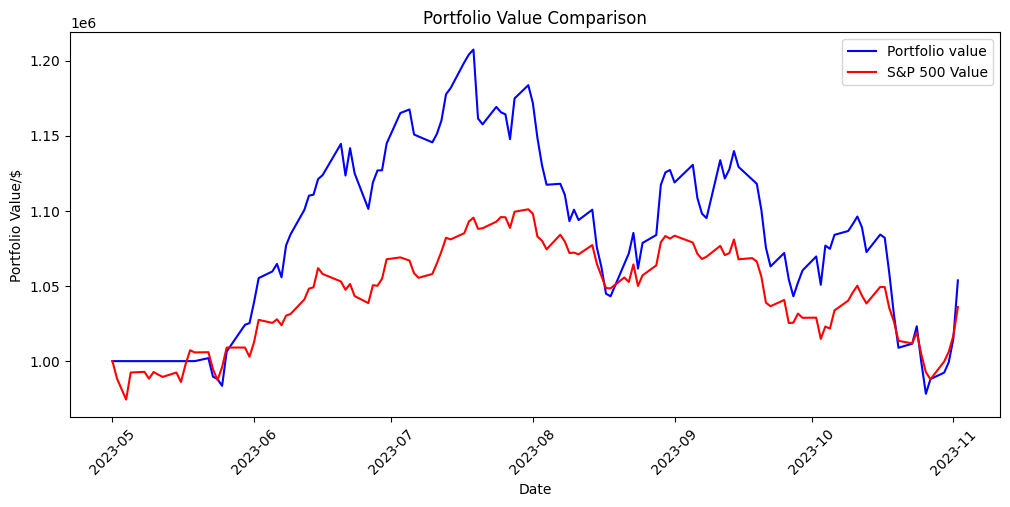

In [14]:
processor.plot()